# Tanvi's GLM
## Prep

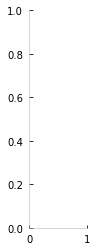

In [1]:
# HIDE CELL
from importlib import reload

import matplotlib.pylab as plt
import numpy as np

import deps
reload(deps)

alldat, dat_LFP, dat_ST = deps.get_data()
dat = alldat[0]
sp, neu, trial_starts = deps.convert_raster_to_spiketimes(dat)
events_df = deps.convert_events_to_dataframe(dat, trial_starts,
                                             event_names=('gocue', 'response_time','feedback_time'),
                                             condition_names=('response','contrast_right','contrast_left','feedback_type'))

spykes_times = deps.spykes_get_times(sp, neu)

dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high

## Encode stimulus onset into spike trains using a Poisson GLM

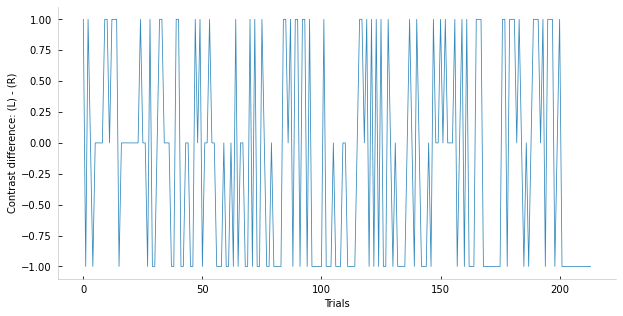

95


In [2]:
#Make contrast matrix
cL = dat['contrast_left']; cR = dat['contrast_right']
cdiff = np.empty_like(cL)

for i in range(len(cL)):
    cdiff[i] = 1*(cL[i]>cR[i]) + (-1)*(cL[i] < cR[i]) + 0*(cL[i] == cR[i])

f=plt.figure(figsize=(10,5))
plt.plot(cdiff); plt.xlabel('Trials'); plt.ylabel('Contrast difference: (L) - (R)'); plt.show()
print(np.sum(cdiff<0))

## Run dimension reduction and decoding decisions

## Dimension Reduction

In [3]:
# prepare input data

all_spikes = dat['spks']
print('neurons, trials, time_bins: ', all_spikes.shape)
# neurons, trials, time_bins
NN = all_spikes.shape[0] # number of neurons
N_trials = all_spikes.shape[1] # number of trials
N_time = all_spikes.shape[2] # number of time_bins



neurons, trials, time_bins:  (734, 214, 250)


In [4]:

go_cues = dat['gocue']
print('go_cues: ', go_cues.shape)

response_times = dat['response_time']
print('response_times: ', response_times.shape)

# get the max time length
stim_onset = 51
max_len = int(np.ceil(100*np.max(go_cues))) + stim_onset
print(max_len)

data = np.reshape(all_spikes[:,:,stim_onset:max_len], (NN, -1)).T 
print(data.shape)


go_cues:  (214, 1)
response_times:  (214, 1)
170
(25466, 734)


### DR - ICA

In [5]:
# use ICA 

from sklearn.decomposition import FastICA

transformer = FastICA(n_components=3, random_state=0)
X_transformed = transformer.fit_transform(data)
print(X_transformed.shape)


(25466, 3)


## Decoding decision

In [6]:
# prepare the y labels for the x input

choice_responses = dat['response']
print(choice_responses.shape)

print('left trials: ', len(np.where(choice_responses < 0)[0]))
print('right trials: ', len(np.where(choice_responses > 0)[0]))
print('no response trials: ', len(np.where(choice_responses == 0)[0]))

idxs = np.where(choice_responses < 0)[0]
idxs = np.append(idxs, np.where(choice_responses > 0)[0])

Y = choice_responses[idxs]
print(Y.shape)


(214,)
left trials:  69
right trials:  71
no response trials:  74
(140,)


## Linear Discriminant Analysis


[1.]
0.9285714285714286


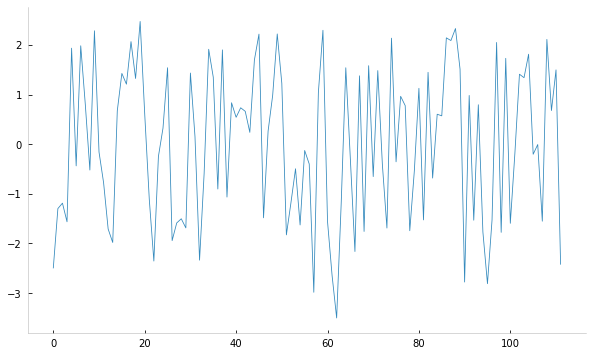

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# gocue = (np.ceil((dat['gocue']*100)))
# end_bin = np.int(np.max(gocue))

# spike_data = np.reshape(dat['spks'][:,idxs,51:51+end_bin], (NN,-1))  #shape is neurons by time and trials
# spike_data = spike_data - np.mean(spike_data, axis=1)[:,np.newaxis]  #subtract mean

# choices = np.repeat(dat['response'][idxs,], end_bin)

# # split into training and test
# X_train, X_test, y_train, y_test = train_test_split(spike_data.T, choices, test_size=0.3, random_state=0)


model = LinearDiscriminantAnalysis(solver = 'svd',store_covariance=True)

input_X = np.swapaxes(all_spikes, 0, 1)
input_X = np.reshape(np.mean(input_X[:,:,stim_onset:max_len], axis=2), (N_trials, -1)) 

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(input_X[idxs], Y, test_size=0.2, random_state=0)


X_transform_LDA = model.fit_transform(X_train,y_train)
print(model.explained_variance_ratio_)
print(model.score(X_test,y_test))
plt.figure(figsize= (10, 6))
plt.plot(X_transform_LDA)


## Naive Bayes Classifier

In [8]:
# use Bernoulli naive bayes to classify 

from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()


X = X_transformed.reshape((N_trials, -1))[idxs]

clf.fit(X, Y)


BernoulliNB()

In [9]:
print(X.shape)
print(N_trials)

(140, 357)
214


## Cross-validation and evaluation

In [10]:
from sklearn.model_selection import cross_validate 

scores = cross_validate(clf, X, Y, cv=3, return_train_score=True)

print(scores)
score = np.mean(scores['test_score'])
print(score)


{'fit_time': array([0.00198865, 0.00158048, 0.00159335]), 'score_time': array([0.00078034, 0.00070524, 0.00070667]), 'test_score': array([0.65957447, 0.61702128, 0.54347826]), 'train_score': array([0.95698925, 0.92473118, 0.95744681])}
0.6066913351834721


### Find the optimal number of reduced components

In [11]:
# find the optimal number of reduced components

components = [range(20), 200, 400]
cv = 5

val_scores = []
# do dim reduction
for comp in components:
  transformer = FastICA(n_components=comp, random_state=0)
  X_transformed = transformer.fit_transform(data)
  print('dim reduced X: ', X_transformed.shape)

  X = X_transformed.reshape((N_trials, -1))[idxs]
  # Y = choice_responses[idxs]

  # cross validate
  scores = cross_validate(clf, X, Y, cv=cv)
  score = np.mean(scores['test_score'])
  val_scores.append(score)

print('scores: ', val_scores)


TypeError: '>' not supported between instances of 'range' and 'int'

In [ ]:
# plotting the scores vs components

plt.plot(components, val_scores, 'o')
plt.title('scores vs. ICA N_components')


### Continue with plots

In [ ]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

In [ ]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


In [ ]:
#@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [ ]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

In [ ]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


In [ ]:
# plot the LFP

is_correct = np.sign(response)==np.sign(vis_left-vis_right)
isort = np.argsort(-is_correct.astype('float32') + response/10) # sort by correct, and then by response

nwrong = np.sum(is_correct)
plt.figure(figsize=(20,6))
for j in range(len(dat['lfp'])):
  ax = plt.subplot(2,6,j+1)
  plt.imshow(dat['lfp'][j, isort], cmap = 'bwr', vmax = 50, vmin=-50, aspect='auto')
  plt.title('Area %s'%dat['brain_area_lfp'][j])
  
  plt.plot([0, NT], [nwrong, nwrong], 'r')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  


In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0))
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices')

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices')

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0))
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices')


In [ ]:
# plot the spike waveforms for some neurons. Sometimes these can tell us what cell type the neuron is 
# (i.e. fast spiking interneurons have short waveforms)

for j in range(7):
  ax = plt.subplot(1,7,j+1)
  kk = 140 + j * 50
  wav = dat['waveform_w'][kk] @ dat['waveform_u'][kk]
  plt.plot(wav)
  ax.set(xlabel = 'time samples', title ='unit %d'%kk, ylabel = 'normalized units')

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')


